# auto regressive transformer https://fast-transformers.github.io/

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change. But blacklist large modules
%load_ext autoreload
%autoreload 2
%aimport -pandas
%aimport -torch
%aimport -numpy
%aimport -matplotlib
%aimport -dask
%aimport -functools
%aimport -tqdm
%aimport -pytorch_lightning
%matplotlib inline

In [2]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback


import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:

from neural_processes.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from neural_processes.plot import plot_from_loader

from neural_processes.dict_logger import DictLogger
from neural_processes.utils import PyTorchLightningPruningCallback
from neural_processes.train import main, objective, add_number, run_trial

from neural_processes.models.neural_process.lightning import PL_NP, PL_ANP, PL_ANPRNN

from neural_processes.models.transformer import PL_Transformer
from neural_processes.models.transformer_seq2seq import TransformerSeq2Seq_PL
from neural_processes.models.transformer_seq2seq_autor import TransformerSeq2SeqAutoR_PL

from neural_processes.models.lstm_seqseq import LSTMSeq2Seq_PL
from neural_processes.models.lstm_std import LSTM_PL_STD

In [5]:
# Params
device='cuda'
use_logy=False

In [6]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("autoregt.ipynb")

# Load kaggle smart meter data

In [7]:
df_train, df_val, df_test = get_smartmeter_df(
#     indir=Path('./data/smart-meters-in-london'), 
#     use_logy=False, 
#     max_files=40
)

In [8]:
data_train = SmartMeterDataSet(
    df_train, 200, 400)
b = data_train[10]
b = collate_fns(110, 210, sample=True)([b])
[bb.shape for bb in b]

[torch.Size([1, 100, 17]),
 torch.Size([1, 100, 1]),
 torch.Size([1, 147, 17]),
 torch.Size([1, 147, 1])]

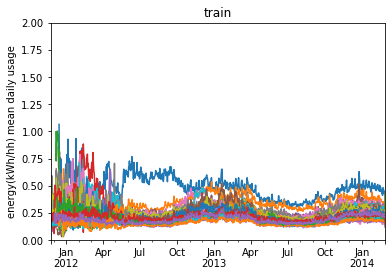

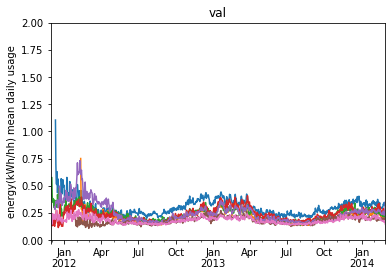

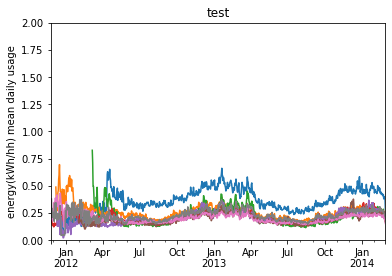

In [9]:
plt.figure()
for name,g in df_train.groupby('block'):
    g['energy(kWh/hh)'].resample('D').mean().plot(ax=plt.gca(), ylim=[0,2])
plt.title('train')
plt.ylabel('energy(kWh/hh) mean daily usage')
plt.show()

plt.figure()
for name,g in df_val.groupby('block'):
    g['energy(kWh/hh)'].resample('D').mean().plot(ax=plt.gca(), ylim=[0,2])
plt.title('val')
plt.ylabel('energy(kWh/hh) mean daily usage')
plt.show()

plt.figure()
for name,g in df_test.groupby('block'):
    g['energy(kWh/hh)'].resample('D').mean().plot(ax=plt.gca(), ylim=[0,2])
plt.title('test')
plt.ylabel('energy(kWh/hh) mean daily usage')
plt.show()

In [10]:
# df_train[['energy(kWh/hh)']].resample('30T').mean().plot(title='train', ylim=[0,3])
# df_val[['energy(kWh/hh)']].resample('30T').mean().plot(title='val', ylim=[0,3])
# df_test[['energy(kWh/hh)']].resample('30T').mean().plot(title='test', ylim=[0,3])

# MODEL (move to src)

# Experiments

In [11]:
# Summarize results


def summarize_results(results):
    result_dfs = []
    for k in results:
        v = results[k]
        df = pd.DataFrame(v).mean()
        df.name = k+'_mean'
        df['n'] = len(v)
        result_dfs.append(df)

#         df = pd.DataFrame(v).std()
#         df.name = k+'_std'
#         df['n'] = len(v)
#         result_dfs.append(df)

    if len(result_dfs)==0:
        return None
    result_df = pd.concat(result_dfs, 1).T
    
    return result_df.sort_values('agg_test_score').T

In [12]:
default_user_attrs = {
    'x_dim': 17,
    'y_dim': 1,
    'vis_i': '670',
    'num_workers': 3,
    'num_context': 48 * 3,
    'num_extra_target': 48 * 3,
    'max_nb_epochs': 40,
    'min_std': 0.005,
    'grad_clip': 40,
    'batch_size': 24,
    'patience': 2,
    'max_epoch_steps': 32 * 600,
}
N = 3

experiments = [
    dict(
        name="TransformerSeq2SeqAutoR_PL",
        PL_MODEL_CLS=TransformerSeq2SeqAutoR_PL,
        params={
            'learning_rate': 3e-5,
            'nlayers': 12,
            'use_lstm': False,
            'hidden_out_size_power': 4,
            "attention_dropout": 0.0,
            "dropout": 0.0,
        },
    ),
]
number = -1
results = collections.defaultdict(list)

INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`


EarlyStopping mode auto is unknown, fallback to auto mode.


INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.


EarlyStopping mode set to min for monitoring val_loss.


INFO:lightning:EarlyStopping mode set to min for monitoring val_loss.


GPU available: True, used: True


INFO:lightning:GPU available: True, used: True


TPU available: False, using: 0 TPU cores


INFO:lightning:TPU available: False, using: 0 TPU cores


CUDA_VISIBLE_DEVICES: [0]


INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
INFO:predict_heading2:trial number=-1002 name=TransformerSeq2SeqAutoR_PL, trial=<optuna.trial.FixedTrial object at 0x7f9524cbf080> params={'learning_rate': 3e-05, 'attention_dropout': 0.0, 'dropout': 0.0, 'hidden_out_size_power': 4, 'nhead_power': 3, 'nlayers': 12, 'use_lstm': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 40, 'num_workers': 3, 'num_extra_target': 144, 'vis_i': '670', 'num_context': 144, 'input_size': 18, 'input_size_decoder': 17, 'output_size': 1, 'patience': 2, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'max_epoch_steps': 19200}



  | Name   | Type                       | Params
------------------------------------------------------
0 | _model | TransformerSeq2SeqAutoRNet | 4 M   


INFO:lightning:
  | Name   | Type                       | Params
------------------------------------------------------
0 | _model | TransformerSeq2SeqAutoRNet | 4 M   


INFO:predict_heading2:val step=0, outputs={'val_loss_p_weighted': tensor(0.1573), 'val_loss_mse': tensor(0.2324), 'val_loss_p': tensor(1.0078), 'val_loss': tensor(1.0078)}


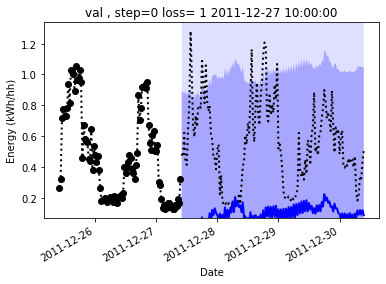

INFO:predict_heading2:val step=799, outputs={'val_loss_p_weighted': tensor(0.0959), 'val_loss_mse': tensor(0.0545), 'val_loss_p': tensor(0.6111), 'val_loss': tensor(0.6111)}


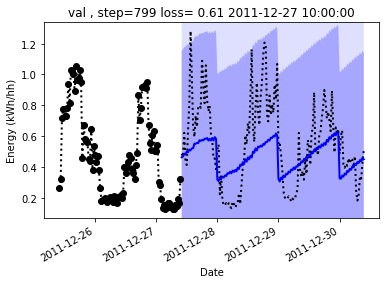

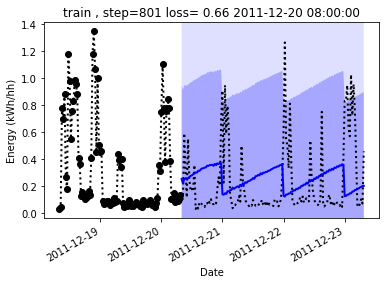

INFO:predict_heading2:train step=801, outputs={'train_loss': tensor(0.5675), 'train_loss_p_weighted': tensor(0.0971), 'train_loss_p': tensor(0.5675), 'train_loss_mse': tensor(0.0121)}


INFO:predict_heading2:val step=1600, outputs={'val_loss_p_weighted': tensor(0.0954), 'val_loss_mse': tensor(0.0515), 'val_loss_p': tensor(0.6080), 'val_loss': tensor(0.6080)}


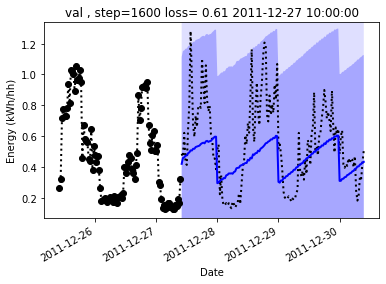

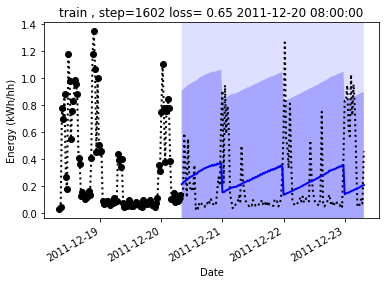

INFO:predict_heading2:train step=1602, outputs={'train_loss': tensor(0.5623), 'train_loss_p_weighted': tensor(0.0956), 'train_loss_p': tensor(0.5623), 'train_loss_mse': tensor(0.0074)}


INFO:predict_heading2:val step=2401, outputs={'val_loss_p_weighted': tensor(0.0950), 'val_loss_mse': tensor(0.0496), 'val_loss_p': tensor(0.6060), 'val_loss': tensor(0.6060)}


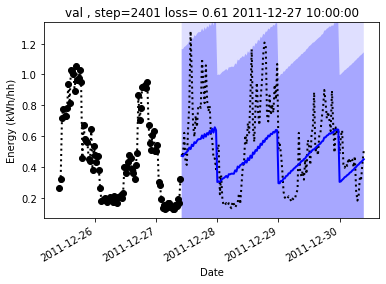

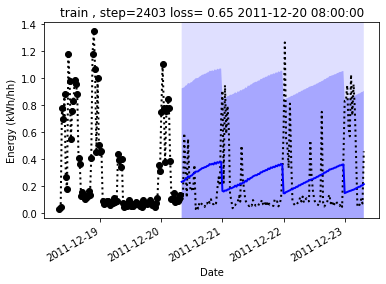

INFO:predict_heading2:train step=2403, outputs={'train_loss': tensor(0.5620), 'train_loss_p_weighted': tensor(0.0960), 'train_loss_p': tensor(0.5620), 'train_loss_mse': tensor(0.0071)}


INFO:predict_heading2:val step=3202, outputs={'val_loss_p_weighted': tensor(0.0952), 'val_loss_mse': tensor(0.0504), 'val_loss_p': tensor(0.6069), 'val_loss': tensor(0.6069)}


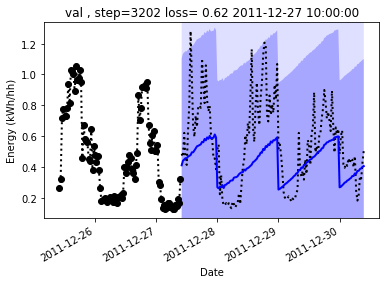

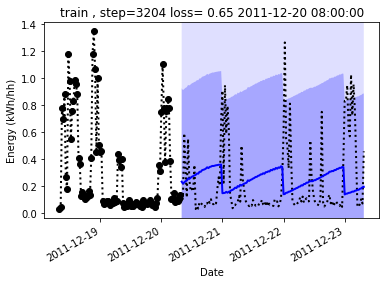

INFO:predict_heading2:train step=3204, outputs={'train_loss': tensor(0.5619), 'train_loss_p_weighted': tensor(0.0956), 'train_loss_p': tensor(0.5619), 'train_loss_mse': tensor(0.0070)}


INFO:predict_heading2:val step=4003, outputs={'val_loss_p_weighted': tensor(0.0951), 'val_loss_mse': tensor(0.0497), 'val_loss_p': tensor(0.6061), 'val_loss': tensor(0.6061)}


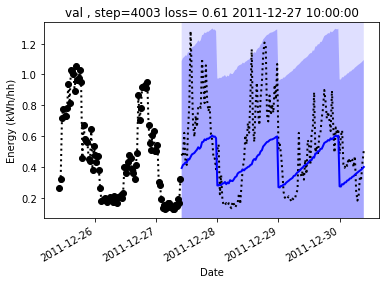

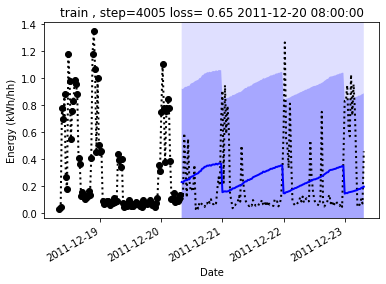

INFO:predict_heading2:train step=4005, outputs={'train_loss': tensor(0.5618), 'train_loss_p_weighted': tensor(0.0954), 'train_loss_p': tensor(0.5618), 'train_loss_mse': tensor(0.0069)}


INFO:predict_heading2:val step=4804, outputs={'val_loss_p_weighted': tensor(0.0946), 'val_loss_mse': tensor(0.0474), 'val_loss_p': tensor(0.6037), 'val_loss': tensor(0.6037)}


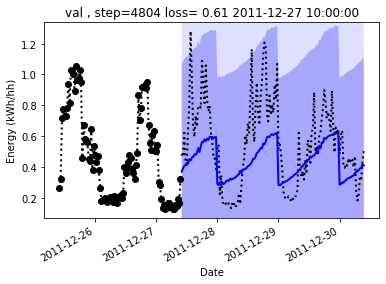

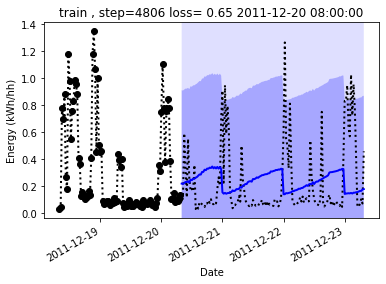

INFO:predict_heading2:train step=4806, outputs={'train_loss': tensor(0.5617), 'train_loss_p_weighted': tensor(0.0958), 'train_loss_p': tensor(0.5617), 'train_loss_mse': tensor(0.0068)}


INFO:predict_heading2:val step=5605, outputs={'val_loss_p_weighted': tensor(0.0947), 'val_loss_mse': tensor(0.0476), 'val_loss_p': tensor(0.6040), 'val_loss': tensor(0.6040)}


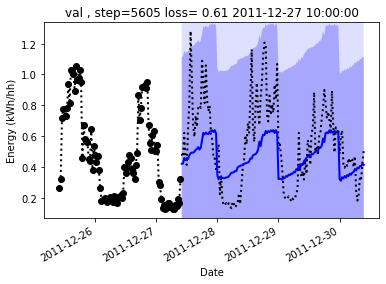

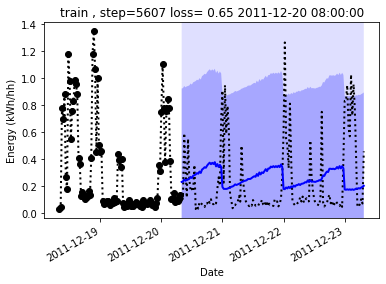

INFO:predict_heading2:train step=5607, outputs={'train_loss': tensor(0.5616), 'train_loss_p_weighted': tensor(0.0960), 'train_loss_p': tensor(0.5616), 'train_loss_mse': tensor(0.0067)}


INFO:predict_heading2:val step=6406, outputs={'val_loss_p_weighted': tensor(0.0938), 'val_loss_mse': tensor(0.0423), 'val_loss_p': tensor(0.5985), 'val_loss': tensor(0.5985)}


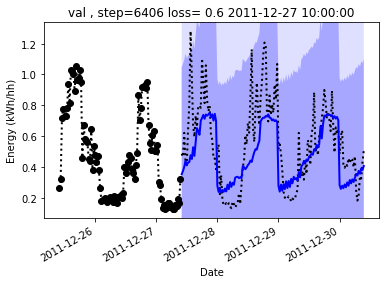

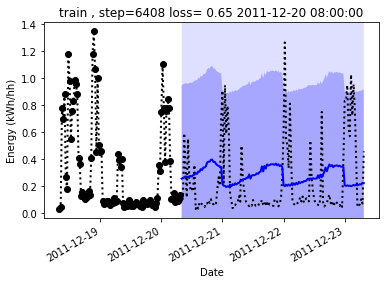

INFO:predict_heading2:train step=6408, outputs={'train_loss': tensor(0.5613), 'train_loss_p_weighted': tensor(0.0959), 'train_loss_p': tensor(0.5613), 'train_loss_mse': tensor(0.0064)}


INFO:predict_heading2:val step=7207, outputs={'val_loss_p_weighted': tensor(0.0937), 'val_loss_mse': tensor(0.0418), 'val_loss_p': tensor(0.5980), 'val_loss': tensor(0.5980)}


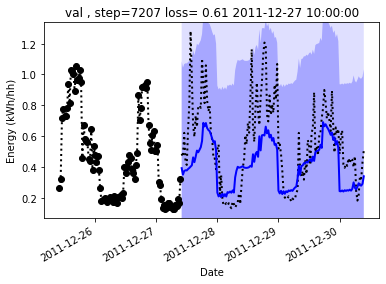

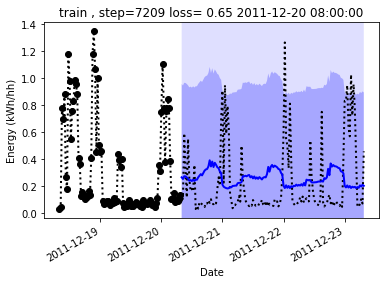

INFO:predict_heading2:train step=7209, outputs={'train_loss': tensor(0.5608), 'train_loss_p_weighted': tensor(0.0957), 'train_loss_p': tensor(0.5608), 'train_loss_mse': tensor(0.0060)}


INFO:predict_heading2:val step=8008, outputs={'val_loss_p_weighted': tensor(0.0935), 'val_loss_mse': tensor(0.0400), 'val_loss_p': tensor(0.5961), 'val_loss': tensor(0.5961)}


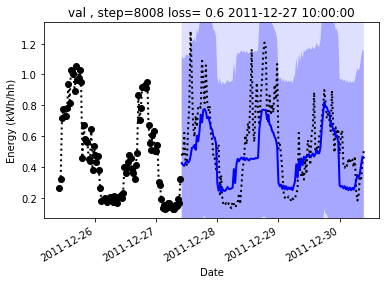

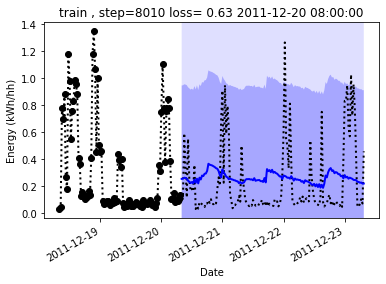

INFO:predict_heading2:train step=8010, outputs={'train_loss': tensor(0.5604), 'train_loss_p_weighted': tensor(0.0956), 'train_loss_p': tensor(0.5604), 'train_loss_mse': tensor(0.0056)}


INFO:predict_heading2:val step=8809, outputs={'val_loss_p_weighted': tensor(0.0935), 'val_loss_mse': tensor(0.0400), 'val_loss_p': tensor(0.5960), 'val_loss': tensor(0.5960)}


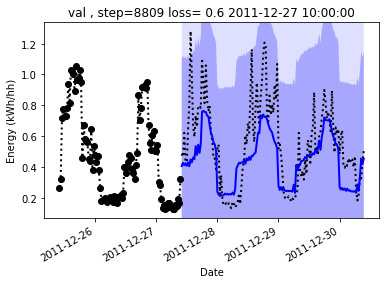

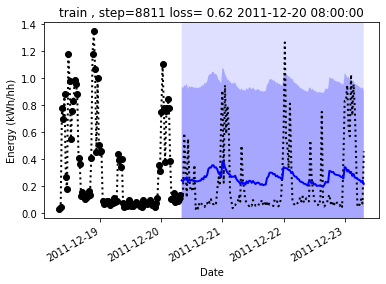

INFO:predict_heading2:train step=8811, outputs={'train_loss': tensor(0.5602), 'train_loss_p_weighted': tensor(0.0957), 'train_loss_p': tensor(0.5602), 'train_loss_mse': tensor(0.0053)}


INFO:predict_heading2:val step=9610, outputs={'val_loss_p_weighted': tensor(0.0931), 'val_loss_mse': tensor(0.0378), 'val_loss_p': tensor(0.5938), 'val_loss': tensor(0.5938)}


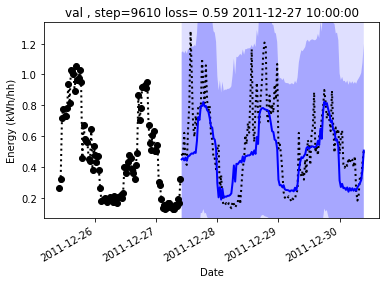

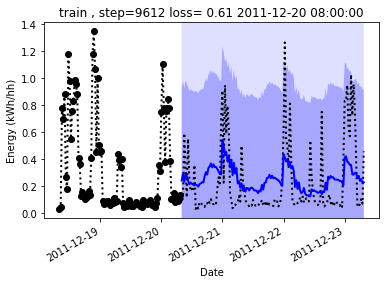

INFO:predict_heading2:train step=9612, outputs={'train_loss': tensor(0.5599), 'train_loss_p_weighted': tensor(0.0956), 'train_loss_p': tensor(0.5599), 'train_loss_mse': tensor(0.0051)}


INFO:predict_heading2:val step=10411, outputs={'val_loss_p_weighted': tensor(0.0932), 'val_loss_mse': tensor(0.0379), 'val_loss_p': tensor(0.5939), 'val_loss': tensor(0.5939)}


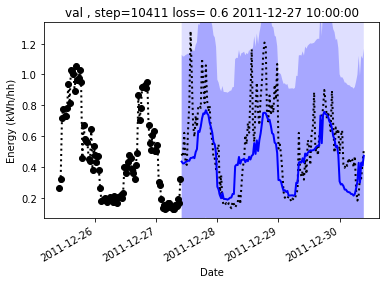

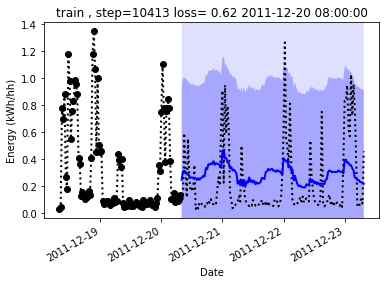

INFO:predict_heading2:train step=10413, outputs={'train_loss': tensor(0.5597), 'train_loss_p_weighted': tensor(0.0948), 'train_loss_p': tensor(0.5597), 'train_loss_mse': tensor(0.0049)}


INFO:predict_heading2:val step=11212, outputs={'val_loss_p_weighted': tensor(0.0933), 'val_loss_mse': tensor(0.0388), 'val_loss_p': tensor(0.5948), 'val_loss': tensor(0.5948)}


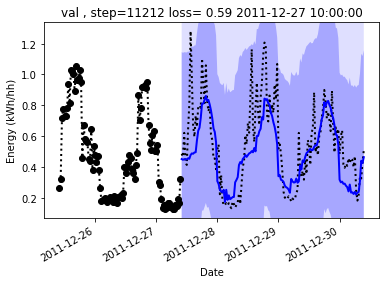

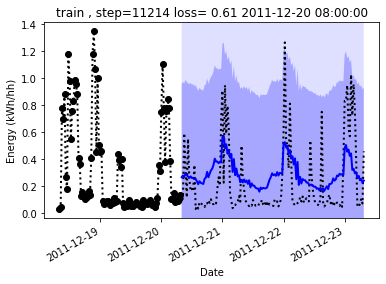

INFO:predict_heading2:train step=11214, outputs={'train_loss': tensor(0.5596), 'train_loss_p_weighted': tensor(0.0953), 'train_loss_p': tensor(0.5596), 'train_loss_mse': tensor(0.0048)}


INFO:predict_heading2:val step=12013, outputs={'val_loss_p_weighted': tensor(0.0932), 'val_loss_mse': tensor(0.0387), 'val_loss_p': tensor(0.5947), 'val_loss': tensor(0.5947)}


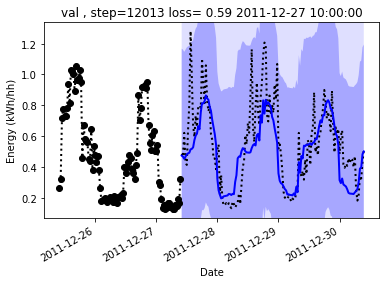

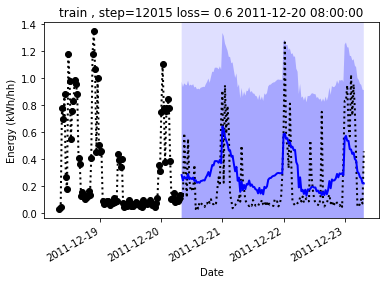

INFO:predict_heading2:train step=12015, outputs={'train_loss': tensor(0.5595), 'train_loss_p_weighted': tensor(0.0952), 'train_loss_p': tensor(0.5595), 'train_loss_mse': tensor(0.0047)}
Epoch    14: reducing learning rate of group 0 to 3.0000e-06.


INFO:predict_heading2:val step=12814, outputs={'val_loss_p_weighted': tensor(0.0933), 'val_loss_mse': tensor(0.0385), 'val_loss_p': tensor(0.5946), 'val_loss': tensor(0.5946)}


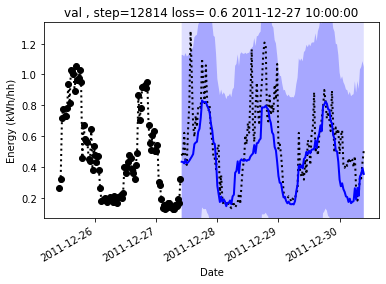

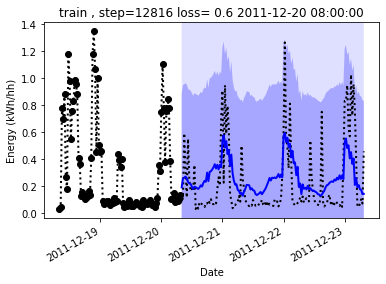

INFO:predict_heading2:train step=12816, outputs={'train_loss': tensor(0.5592), 'train_loss_p_weighted': tensor(0.0952), 'train_loss_p': tensor(0.5592), 'train_loss_mse': tensor(0.0044)}


Epoch 00016: early stopping triggered.


INFO:lightning:Epoch 00016: early stopping triggered.



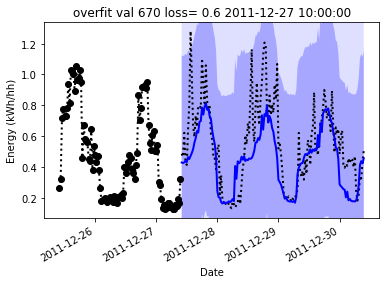

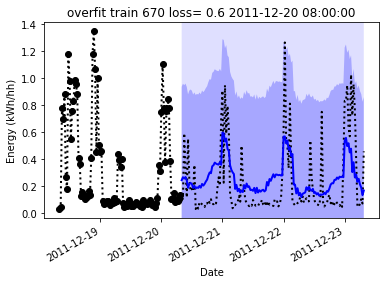

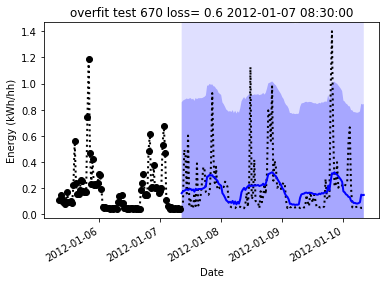

INFO:predict_heading2:Loading checkpoint /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/lightning_logs/TransformerSeq2SeqAutoR_PL/version_-1002/_ckpt_epoch_11.ckpt


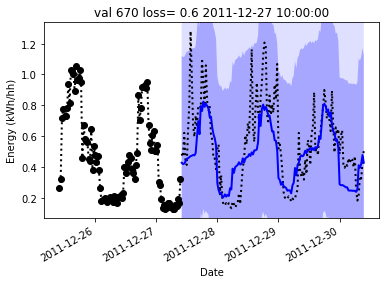

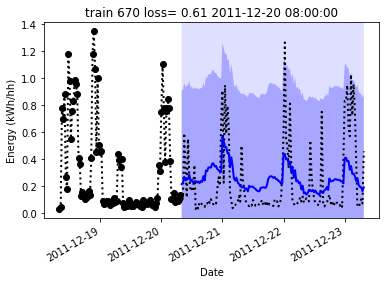

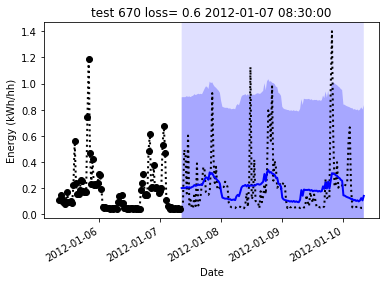

INFO:predict_heading2:test step=12816, outputs={'test_loss_mse': tensor(0.0400), 'test_loss_p': tensor(0.5961), 'test_loss_p_weighted': tensor(0.0935), 'test_loss': tensor(0.5961)}
--------------------------------------------------------------------------------
TEST RESULTS
{'test_loss': tensor(0.5961),
 'test_loss_mse': tensor(0.0400),
 'test_loss_p': tensor(0.5961),
 'test_loss_p_weighted': tensor(0.0935)}
--------------------------------------------------------------------------------



In [13]:
# TEST
exp=experiments[0]
trial, trainer, model = run_trial(
    user_attrs = default_user_attrs,
    **exp)

0 {'name': 'TransformerSeq2SeqAutoR_PL', 'PL_MODEL_CLS': <class 'neural_processes.models.transformer_seq2seq_autor.TransformerSeq2SeqAutoR_PL'>, 'params': {'learning_rate': 3e-05, 'nlayers': 12, 'use_lstm': False, 'hidden_out_size_power': 4, 'attention_dropout': 0.0, 'dropout': 0.0}}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`


EarlyStopping mode auto is unknown, fallback to auto mode.


INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.


EarlyStopping mode set to min for monitoring val_loss.


INFO:lightning:EarlyStopping mode set to min for monitoring val_loss.


GPU available: True, used: True


INFO:lightning:GPU available: True, used: True


TPU available: False, using: 0 TPU cores


INFO:lightning:TPU available: False, using: 0 TPU cores


CUDA_VISIBLE_DEVICES: [0]


INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
INFO:predict_heading2:trial number=-1000 name=TransformerSeq2SeqAutoR_PL, trial=<optuna.trial.FixedTrial object at 0x7f952848b390> params={'learning_rate': 3e-05, 'attention_dropout': 0.0, 'dropout': 0.0, 'hidden_out_size_power': 4, 'nhead_power': 3, 'nlayers': 12, 'use_lstm': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 40, 'num_workers': 3, 'num_extra_target': 144, 'vis_i': '670', 'num_context': 144, 'input_size': 18, 'input_size_decoder': 17, 'output_size': 1, 'patience': 2, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/lightning_logs/TransformerSeq2SeqAutoR_PL/version_-1000/_ckpt_epoch_1.ckpt


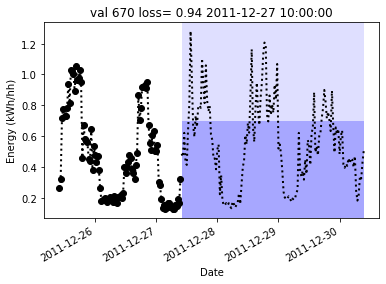

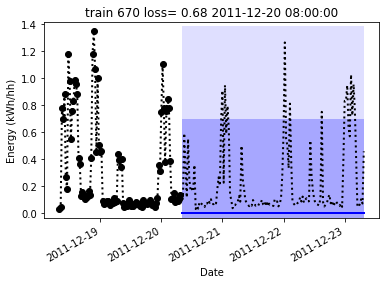

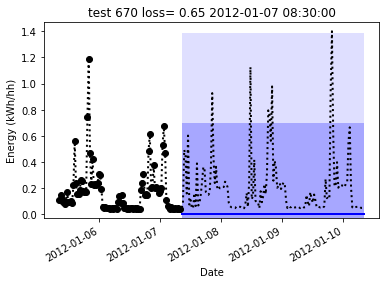

INFO:predict_heading2:test step=0, outputs={'test_loss_mse': tensor(0.0858), 'test_loss_p': tensor(0.6435), 'test_loss_p_weighted': tensor(0.1008), 'test_loss': tensor(0.6435)}
--------------------------------------------------------------------------------
TEST RESULTS
{'test_loss': tensor(0.6435),
 'test_loss_mse': tensor(0.0858),
 'test_loss_p': tensor(0.6435),
 'test_loss_p_weighted': tensor(0.1008)}
--------------------------------------------------------------------------------

1 {'name': 'TransformerSeq2SeqAutoR_PL', 'PL_MODEL_CLS': <class 'neural_processes.models.transformer_seq2seq_autor.TransformerSeq2SeqAutoR_PL'>, 'params': {'learning_rate': 3e-05, 'nlayers': 12, 'use_lstm': False, 'hidden_out_size_power': 4, 'attention_dropout': 0.0, 'dropout': 0.0}}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`


EarlyStopping mode auto is unknown, fallback to auto mode.


INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.


EarlyStopping mode set to min for monitoring val_loss.


INFO:lightning:EarlyStopping mode set to min for monitoring val_loss.


GPU available: True, used: True


INFO:lightning:GPU available: True, used: True


TPU available: False, using: 0 TPU cores


INFO:lightning:TPU available: False, using: 0 TPU cores


CUDA_VISIBLE_DEVICES: [0]


INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
INFO:predict_heading2:trial number=-1100 name=TransformerSeq2SeqAutoR_PL, trial=<optuna.trial.FixedTrial object at 0x7f9524c95898> params={'learning_rate': 3e-05, 'attention_dropout': 0.0, 'dropout': 0.0, 'hidden_out_size_power': 4, 'nhead_power': 3, 'nlayers': 12, 'use_lstm': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 40, 'num_workers': 3, 'num_extra_target': 144, 'vis_i': '670', 'num_context': 144, 'input_size': 18, 'input_size_decoder': 17, 'output_size': 1, 'patience': 2, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'max_epoch_steps': 19200}



  | Name   | Type                       | Params
------------------------------------------------------
0 | _model | TransformerSeq2SeqAutoRNet | 4 M   


INFO:lightning:
  | Name   | Type                       | Params
------------------------------------------------------
0 | _model | TransformerSeq2SeqAutoRNet | 4 M   


INFO:predict_heading2:val step=0, outputs={'val_loss_p_weighted': tensor(0.1573), 'val_loss_mse': tensor(0.2560), 'val_loss_p': tensor(1.0033), 'val_loss': tensor(1.0033)}


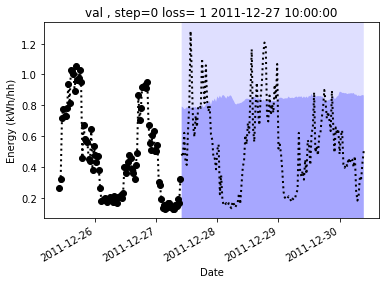

INFO:predict_heading2:val step=799, outputs={'val_loss_p_weighted': tensor(0.0958), 'val_loss_mse': tensor(0.0544), 'val_loss_p': tensor(0.6110), 'val_loss': tensor(0.6110)}


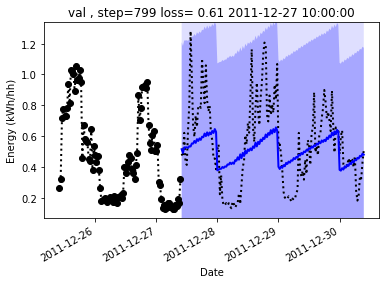

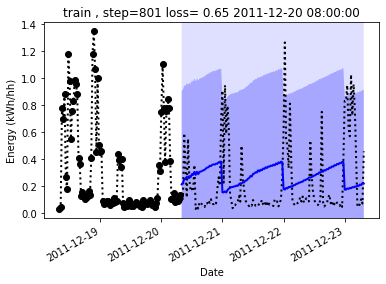

INFO:predict_heading2:train step=801, outputs={'train_loss': tensor(0.5676), 'train_loss_p_weighted': tensor(0.0971), 'train_loss_p': tensor(0.5676), 'train_loss_mse': tensor(0.0122)}


INFO:predict_heading2:val step=1600, outputs={'val_loss_p_weighted': tensor(0.0958), 'val_loss_mse': tensor(0.0540), 'val_loss_p': tensor(0.6106), 'val_loss': tensor(0.6106)}


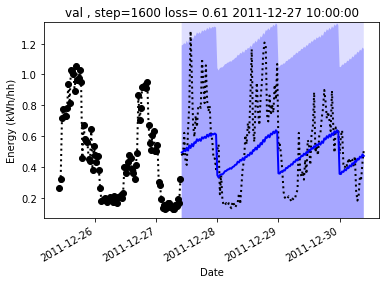

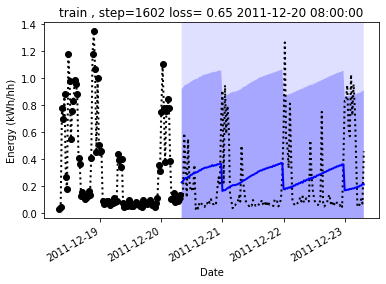

INFO:predict_heading2:train step=1602, outputs={'train_loss': tensor(0.5622), 'train_loss_p_weighted': tensor(0.0957), 'train_loss_p': tensor(0.5622), 'train_loss_mse': tensor(0.0073)}


/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...




ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-bf1e89617682>", line 7, in <module>
    **exp)
  File "/media/wassname/Storage5/projects2/3ST/attentive-neural-processes/neural_processes/train.py", line 146, in run_trial
    plot_from_loader(model.val_dataloader(), model, i=670, title='overfit val 670')
  File "/media/wassname/Storage5/projects2/3ST/attentive-neural-processes/neural_processes/plot.py", line 125, in plot_from_loader
    y_pred, losses, extra = model(context_x, context_y, target_x, target_y)
  File "/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 541, in __call__
    result = self.forward(*input, **kwargs)
  File "/m

KeyboardInterrupt: 

In [14]:
for i in range(N):
    for exp in experiments:
        print(i, exp)
        trial, trainer, model = run_trial(
            user_attrs = default_user_attrs,
            number=number*i*100-1000,
            **exp)

        name = trainer.logger.name
        r=trainer.logger.metrics[-1]
        if 'agg_test_score' in r:
            results[name].append(r)

            display(summarize_results(results))

In [ ]:
display(summarize_results(results))

In [ ]:
result_dfs = []
for k in results:
    v = results[k]
    df = pd.DataFrame(v).mean()
    df = pd.concat([pd.DataFrame(v).mean().rename(lambda x:'mean_' + x),
    pd.DataFrame(v).std().rename(lambda x:'std_' + x),
    pd.DataFrame(v).min().rename(lambda x:'min_' + x)])

    df.name = k
    df['n'] = len(v)
    result_dfs.append(df)

#         df = pd.DataFrame(v).std()
#         df.name = k+'_std'
#         df['n'] = len(v)
#         result_dfs.append(df)


result_df = pd.concat(result_dfs, 1).T
result_df.sort_values('min_agg_test_score').T

# Manual exp

In [ ]:
number=None

# Hyperparam

In [ ]:
from neural_processes.train import objective
import argparse 

In [ ]:
optuna_path = Path('./optuna_result2')
optuna_path.mkdir(exist_ok=True)

In [ ]:
for PL_MODEL_CLS in [TransformerSeq2SeqAutoR_PL, TransformerAutoR_PL]:
    name = str(PL_MODEL_CLS.__name__)
    func = functools.partial(objective,
                             PL_MODEL_CLS=PL_MODEL_CLS,
                             name=name,
                             user_attrs=default_user_attrs)

    parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
    parser.add_argument(
        '--pruning',
        '-p',
        action='store_true',
        help='Activate the pruning feature. `MedianPruner` stops unpromising '
        'trials at the early stages of training.')
    args = parser.parse_args(['-p'])

    pruner = optuna.pruners.MedianPruner(
        n_warmup_steps=1,
        n_startup_trials=6) if args.pruning else optuna.pruners.NopPruner()
    pruner = optuna.pruners.PercentilePruner(75.0)

    study = optuna.create_study(direction='minimize',
                                pruner=pruner,
                                storage=f'sqlite:///{optuna_path}/{name}.db',
                                study_name=name,
                                load_if_exists=True)

#     1/0
    study.optimize(func=func,
                   n_trials=200,
                   timeout=pd.Timedelta('0.5d').total_seconds())

    print('Number of finished trials: {}'.format(len(study.trials)))

    print('Best trial:')
    trial = study.best_trial

    print('  Value: {}'.format(trial.value))

    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

    # shutil.rmtree(MODEL_DIR)

    df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
    print(df.sort_values('value'))

In [ ]:
PL_MODEL_CLS

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')